# Constitution of a corpus of NLP papers from two sources: ACL Anthology and ArXiv

**In this Notebook**: We will create two `Corpus` objects and populate them with `Paper`(s), whose content will be further investigated. We use two sources of papers (XML format) and metadata: [the ACL Anthology](#a-acl-corpus) and [ArXiv](#b-arxiv-corpus).

In [1]:
import pandas as pd
import numpy as np
import warnings
import xml.etree.ElementTree as ET
import json
from typing import Tuple, List
import pickle
import re
import tqdm
import os
from matplotlib import pyplot as plt
from collections import Counter
import sys
sys.path.insert(0, '../') # add parent directory (containing the util module) to path
import utils.Corpus

## A. ACL corpus

### 1. Initial data inspection

Data source: [ACL Anthology corpus](https://github.com/shauryr/ACL-anthology-corpus) by Shaurya Rohatgi (metadata + grobid extractions as XML files).

In [7]:
XML_FILES_DIR = "../data/acl/tei.xml/"
METADATA_PATH = "../data/acl/acl-publication-info.74k.v3.full-sections-partial-topic-labels.pkl"

Have a look at the complete metadata provided in Shaurya Rohatgi's corpus:

In [8]:
df = pd.read_pickle(METADATA_PATH)
print(df.shape)
df.columns

(73285, 26)


Index(['acl_id', 'abstract', 'full_text', 'corpus_paper_id', 'pdf_hash',
       'numcitedby', 'url', 'publisher', 'address', 'year', 'month',
       'booktitle', 'author', 'title', 'pages', 'doi', 'number', 'volume',
       'journal', 'editor', 'isbn', 'ENTRYTYPE', 'ID', 'language', 'note',
       'Model Predicted Topics'],
      dtype='object')

Check the years:

In [9]:
df["year"] = df["year"].astype(int)
df["year"].describe()

count    73285.000000
mean      2011.292707
std          9.885551
min       1952.000000
25%       2007.000000
50%       2014.000000
75%       2019.000000
max       2022.000000
Name: year, dtype: float64

Also check that for every article mentionned in the metadata, we have the corresponding XML file stored.

In [ ]:
# # for every acl_id, check that the xml file exists
# for acl_id in tqdm.tqdm(list(df["acl_id"])):
#     path = f"{XML_FILES_DIR}/{acl_id}.tei.xml"
#     if not os.path.exists(path):
#         print(f"File {path} does not exist")
#         break

Check for attributes with missing values:

In [10]:
for col in df.columns:
    none_rows = df[df[col].isnull()].shape[0]
    if none_rows > 0:
        print(f"No {col}: {none_rows}")

No abstract: 5616
No full_text: 5830
No pdf_hash: 1209
No publisher: 10119
No address: 7192
No month: 7323
No booktitle: 2041
No author: 667
No pages: 13807
No doi: 43607
No number: 71811
No volume: 71445
No journal: 71248
No editor: 73272
No isbn: 71915
No language: 70265
No note: 73088
No Model Predicted Topics: 42254


We can directly exclude papers that are explicitly not in English, and posters (at least, papers whose id contains "poster"):

In [11]:
df["language"].value_counts()

language
French                 1453
English                1371
Chinese                 188
German                    6
Portuguese (Brazil)       2
Name: count, dtype: int64

In [12]:
len([id_ for id_ in list(df["acl_id"].values) if "poster" in id_])

266

In [24]:
df.columns

Index(['acl_id', 'abstract', 'full_text', 'corpus_paper_id', 'pdf_hash',
       'numcitedby', 'url', 'publisher', 'address', 'year', 'month',
       'booktitle', 'author', 'title', 'pages', 'doi', 'number', 'volume',
       'journal', 'editor', 'isbn', 'ENTRYTYPE', 'ID', 'language', 'note',
       'Model Predicted Topics'],
      dtype='object')

We note that even if they have different ids, some papers seem to be duplicated, i.e., they have the same title, authors, publisher and year of publication:

In [27]:
dupl_titles = df.duplicated(subset = ["title"])
print(dupl_titles[dupl_titles == True].shape)

(775,)


In [35]:
dupl = df.duplicated(subset = ["title", "author", "year", "publisher"])
print(dupl[dupl == True].shape)
i = dupl[dupl == True].index[0]
t = df.loc[i, "title"]
df[df["title"] == t]

(267,)


,acl_id,abstract,full_text,corpus_paper_id,pdf_hash,numcitedby,url,publisher,address,year,...,number,volume,journal,editor,isbn,ENTRYTYPE,ID,language,note,Model Predicted Topics
5060,S14-2017,We describe our approach for the SemEval-2014 ...,We describe our approach for the SemEval-2014 ...,14181656,966bf176ca89ec7b87ed86c3cfcc7e43db5730f8,14,https://aclanthology.org/S14-2017,Association for Computational Linguistics,"Dublin, Ireland",2014,...,None,None,None,None,None,inproceedings,silva-etal-2014-biocom,None,None,NaN
5078,S14-2018,We describe our approach for the SemEval-2014 ...,We describe our approach for the SemEval-2014 ...,208317455,210cc85c75ad5a2d1350b7c670fdf88c13fc156a,1,https://aclanthology.org/S14-2018,Association for Computational Linguistics,"Dublin, Ireland",2014,...,None,None,None,None,None,inproceedings,silva-etal-2014-biocom-usp,None,None,NaN


In [10]:
# ignore warnings
warnings.filterwarnings("ignore")

# get rid of the non-english papers
df_c = df[(df["language"] == "English") | (df["language"].isnull())]
print(df_c.shape)

# get rid of the posters
for i, row in df_c.iterrows():
    if "poster" in df_c.loc[i, "acl_id"]:
        df_c.drop(i, inplace=True)

print(df_c.shape)

(71636, 26)
(71553, 26)


In [11]:
# # save in pickle format
# df_c.to_pickle("acl-metadata-full-en_no-p.pkl")

### 2. Create `Corpus` object and extract papers content

Below, we create a `Corpus` and provide it with the paths to find useful XML papers and metadata.

In [11]:
# XML_FILES_DIR = "../data/acl/tei.xml/"
# METADATA_PATH = "../data/acl/acl-metadata-full-en_no-p.pkl"

# corpus_ACL = utils.Corpus.Corpus(xml_dir_path= XML_FILES_DIR,
#                     metadata_path = METADATA_PATH,
#                     name = "ACL")

When calling `load_papers`, we extract the content of all the XML files in the corpus to create some `Paper` objects. This process can take a long time to run (~9:35:20 in our case, ran on Grid5000).

In [3]:
# corpus_ACL.load_papers()

100%|██████████| 71553/71553 [9:35:20<00:00,  2.07it/s]   


Then, the method `preprocess_papers` will sort sentences from `Paper` objects into two categories: candidates (for containing claims) and non candidates, based on the section that they belong to (e.g the sentences of a section named "Experimental setup" will be considered as non candidates).

In [4]:
# corpus_ACL.preprocess_papers()

In [5]:
# # serialize the corpus for later access
# with open("../data/acl/corpus_ACL.pkl", "wb") as f:
#     pickle.dump(corpus_ACL, f)

In [4]:
# with open("../data/acl/corpus_ACL.pkl", "rb") as f:
#     corpus_ACL = pickle.load(f)

In [69]:
# Actually, the latest available version of the corpus has been stored as a json file
# Duplicates have been removed (based on the title, author, year, and publisher)
from utils.utils import load_corpus_object

with open("../data/acl/corpus_ACL.json", "r") as f:
    corpus_dict = json.load(f)

corpus_ACL = utils.Corpus.Corpus.from_dict(corpus_dict)

In [70]:
corpus_ACL

In [71]:
p = corpus_ACL.papers[0]

print(p.title)
print(p.abstract)
authors = p.authors
for a in authors:
    print(a.names)

A Study on Word Similarity using Context Vector Models
There is a need to measure word similarity when processing natural languages, especially when using generalization, classification, or example -based approaches. Usually, measures of similarity between two words are defined according to the distance between their semantic classes in a semantic taxonomy . The taxonomy approaches are more or less semantic -based that do not consider syntactic similarit ies. However, in real applications, both semantic and syntactic similarities are required and weighted differently. Word similarity based on context vectors is a mixture of syntactic and semantic similarit ies. In this paper, we propose using only syntactic related co-occurrences as context vectors and adopt information theoretic models to solve the problems of data sparseness and characteristic precision. The probabilistic distribution of co-occurrence context features is derived by parsing the contextual environment of each word , an

### 3. Corpus content inspection

#### Errors

All the encountered errors (e.g a `Paper` object couldn't be correctly initialized because the corresponding XML file is not well-structured) are stored for later analysis. Plus, the "correct" and "incorrect" `Paper` objets are stored separately into `Corpus` attributes `papers` and `papers_with_errors`.

In [72]:
print(len(corpus_ACL.papers))
print(len(corpus_ACL.papers_with_errors))

62227
10828


We can know more about these errors:

In [73]:
corpus_ACL.describe(error_verbose=True)

Corpus 'ACL' was filled with 73055 papers:
  - 62227 papers were successfully loaded
  - 10828 papers could not be loaded

Errors:
  - Parsing error: XML file not well formed : 5523
  - Parsing error: no abstract found : 3163
  - Noisy data: wrong language (sk) : 8
  - Noisy data: wrong language (sq) : 34
  - parsing error: not enough paper content found (<2 distinct sections) : 715
  - Noisy data: wrong language (da) : 155
  - Noisy data: wrong language (de) : 76
  - Noisy data: wrong language (fr) : 636
  - Noisy data: wrong language (sl) : 8
  - Noisy data: wrong language (hr) : 4
  - Noisy data: wrong language (so) : 21
  - Noisy data: wrong language (tr) : 11
  - Noisy data: wrong language (pl) : 21
  - Noisy data: wrong language (pt) : 124
  - Noisy data: wrong language (af) : 1
  - Noisy data: wrong language (et) : 3
  - Noisy data: wrong language (no) : 40
  - Noisy data: wrong language (nl) : 8
  - Noisy data: wrong language (vi) : 26
  - Noisy data: wrong language (es) : 10
 

In [74]:
# collect the encountered errors
errors = [[pe.id, pe.init_error, pe.title, pe.abstract, pe.year] for pe in corpus_ACL.papers_with_errors]
df_errors = pd.DataFrame(errors, columns=["id", "error", "title", "abstract", "year"])
df_errors.to_csv("../data/acl/acl-init-errors.csv", index=False)

In [75]:
df_errors = pd.read_csv("../data/acl/acl-init-errors.csv")
df_errors.groupby("error").count()[["id"]]

,id
error,
Noisy data: wrong language (af),1
Noisy data: wrong language (bn),6
Noisy data: wrong language (cs),5
Noisy data: wrong language (da),155
Noisy data: wrong language (de),76
Noisy data: wrong language (es),10
Noisy data: wrong language (et),3
Noisy data: wrong language (fi),12
Noisy data: wrong language (fr),636


In [76]:
df_errors[df_errors["error"].str.startswith("Noisy data: wrong language")].shape

(1427, 5)

In [77]:
# plot a graph for all the different types of languages contained in the corpus
import re
df_errors_lg = df_errors[df_errors["error"].str.startswith("Noisy data: wrong language")]
df_errors_lg["lg"] = df_errors_lg["error"].apply(lambda x: re.match(re.compile("Noisy data: wrong language (\(.*\))"), x).group(1).strip("()"))
df_errors_lg

C:\Users\cleme\AppData\Local\Temp\ipykernel_14788\1734814697.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_errors_lg["lg"] = df_errors_lg["error"].apply(lambda x: re.match(re.compile("Noisy data: wrong language (\(.*\))"), x).group(1).strip("()"))


,id,error,title,abstract,year,lg
11,W02-1409,Noisy data: wrong language (sk),An {LCS}-Based Approach for Analyzing {J}apane...,Hr q sr g &g h i 5j k ml on qp &j r es p at uk...,2002,sk
17,N01-1004,Noisy data: wrong language (sq),Why Inverse Document Frequency?,NaN,2001,sq
47,C02-1165,Noisy data: wrong language (da),Complexity of Event Structure in {IE} Scenarios,NaN,2002,da
49,2012.iwslt-evaluation.16,Noisy data: wrong language (de),The {NICT} translation system for {IWSLT} 2012,NaN,2012,de
51,C00-2136,Noisy data: wrong language (da),Automatic Acquisition of Domain Knowledge for ...,NaN,2000,da
...,...,...,...,...,...,...
10791,W04-0864,Noisy data: wrong language (so),Some experiments with a Naive {B}ayes {WSD} sy...,NaN,2004,so
10792,W04-1512,Noisy data: wrong language (sq),Dependencies as Categories,NaN,2004,sq
10806,P00-1069,Noisy data: wrong language (da),Word Sense Disambiguation by Learning from Unl...,NaN,2000,da
10820,P04-3009,Noisy data: wrong language (da),Wide Coverage Symbolic Surface Realization,NaN,2004,da


In [78]:
from matplotlib import pyplot as plt

counts = df_errors_lg.groupby("lg").count().sort_values("id", ascending=False)
counts

,id,error,title,abstract,year
lg,,,,,
fr,636,636,636,584,636
da,155,155,155,12,155
zh-tw,148,148,148,6,148
pt,124,124,124,75,124
de,76,76,76,7,76
no,40,40,40,6,40
sv,38,38,38,11,38
sq,34,34,34,9,34
vi,26,26,26,7,26


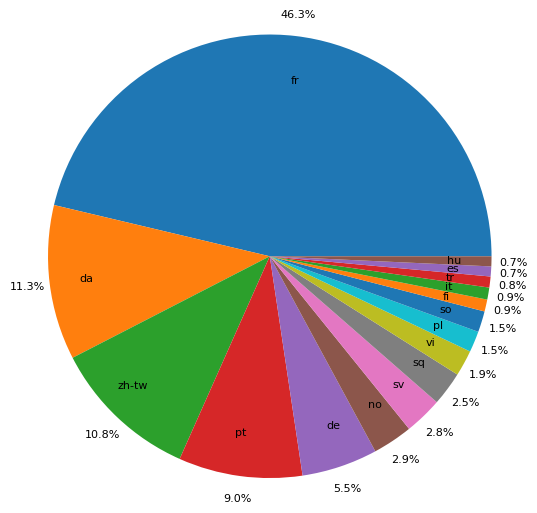

In [79]:
# plot a pie chart to show the repartition of languages in the corpus
languages = [lg for lg in list(counts.index) if counts.loc[lg, "id"] >= 10]
values = [count for count in list(counts.id) if count >=10]

# Label distance: gives the space between labels and the center of the pie
plt.pie(values, labels=languages, labeldistance=.8, autopct='%1.1f%%',
       pctdistance=1.1, textprops = {"fontsize": 8}, rotatelabels = False, radius = 1.5)
plt.show()

#### `Paper` objects

In [80]:
# an example of a Paper object
p = corpus_ACL.papers[123]

# some metadata
print(p.id)
print(p.title)
print(p.abstract)
print(p.year)

R13-1012
A unified lexical processing framework based on the Margin Infused Relaxed Algorithm. A case study on the {R}omanian Language
General natural language processing and text-to-speech applications require certain (lexical level) processing steps in order to solve some frequent tasks such as lemmatization, syllabification, lexical stress prediction and phonetic transcription. These steps usually require knowledge of the word's lexical composition (derivative morphology, inflectional affixes, etc.). For known words all applications use lexicons, but there are always out-of-vocabulary (OOV) words that impede the performance of NLP and speech synthesis applications. In such cases, either rule based or data-driven techniques are used to automatically process these OOV words and generate the desired results. In this paper we describe how the above mentioned tasks can be achieved using a Perceptron with the Margin Infused Relaxed Algorithm (MIRA) and sequence labeling.
2013


In [82]:
# the Corpus to which the Paper belongs
print(p.corpus)

ACL


In [84]:
# the authors of the paper
print(p.authors)
for auth in p.authors:
    print(auth.names)
    print(auth.norm_names) # TO DO: store the normalized names in the json file

['Boro{\\textcommabelow{s}}', 'Tiberiu']
[]


More importantly, we have access to the content of the Paper:

In [85]:
p.content

,id,sentence,section,candidate
0,0,General natural language processing and text-t...,abstract,True
1,1,These steps usually require knowledge of the w...,abstract,True
2,2,"For known words all applications use lexicons,...",abstract,True
3,3,"In such cases, either rule based or data-drive...",abstract,True
4,4,In this paper we describe how the above mentio...,abstract,True
...,...,...,...,...
128,128,We presented a unified data-driven framework t...,Conclusions,True
129,129,"Although, our main focus was on Romanian, the ...",Conclusions,True
130,130,Our results are better than state-of-the-art r...,Conclusions,True
131,131,"In this context, we should emphasize that we s...",Conclusions,True


We can separately look at the candidate sentences (potential claims) and the non candidate ones (those who belong to a section which should, a priori, not contain claims). ONLY RELEVANT FOR ANNOTATION (WHEN SELECTING IRC PAPERS).

In [87]:
p.content[p.content["candidate"] == True]

,id,sentence,section,candidate
0,0,General natural language processing and text-t...,abstract,True
1,1,These steps usually require knowledge of the w...,abstract,True
2,2,"For known words all applications use lexicons,...",abstract,True
3,3,"In such cases, either rule based or data-drive...",abstract,True
4,4,In this paper we describe how the above mentio...,abstract,True
...,...,...,...,...
128,128,We presented a unified data-driven framework t...,Conclusions,True
129,129,"Although, our main focus was on Romanian, the ...",Conclusions,True
130,130,Our results are better than state-of-the-art r...,Conclusions,True
131,131,"In this context, we should emphasize that we s...",Conclusions,True


In [88]:
p.content[p.content["candidate"] == False]

,id,sentence,section,candidate
12,12,There are various methods proposed in the lite...,Lexical processing with MIRA,False
13,13,"For each of them, we will offer a short litera...",Lexical processing with MIRA,False
14,14,The previously proposed methods vary from rule...,Lexical processing with MIRA,False
15,15,"While these are all powerful methodologies, we...",Lexical processing with MIRA,False
16,16,All the lexical processing methods that we pro...,Lexical processing with MIRA,False
17,17,"the tests are reported on OOV words, as we ass...",Lexical processing with MIRA,False
86,86,Phonetic transcription (PT; also referred to a...,Phonetic transcription,False
87,87,"For Romanian, phonetic transcription rules are...",Phonetic transcription,False
88,88,"For the purpose of language independence, data...",Phonetic transcription,False
89,89,Several Machine Learning (ML) methods have bee...,Phonetic transcription,False


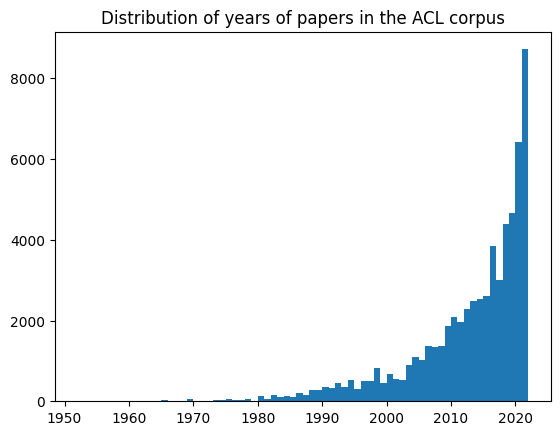

In [90]:
# distribution of years of the papers in the corpus
years = [int(p.year) for p in corpus_ACL.papers]
plt.hist(years, bins=range(min(years), max(years) + 1))
plt.title("Distribution of years of papers in the ACL corpus")
plt.show()

9401


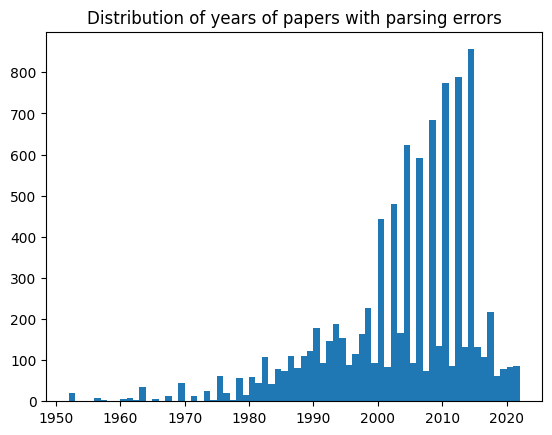

In [91]:
parsing_error_papers = [p for p in corpus_ACL.papers_with_errors if p.init_error.lower().startswith("parsing error")]
print(len(parsing_error_papers))

years = [int(p.year) for p in parsing_error_papers]
plt.hist(years, bins=range(min(years), max(years) + 1))
plt.title("Distribution of years of papers with parsing errors")
plt.show()

## B. ArXiv corpus

### 1. Initial corpus inspection

We load the initial metadata of the entire ArXiv corpus, available on Kaggle.

In [2]:
data = []
with open("../data/arxiv/arxiv-metadata-oai-snapshot.json", "r", errors = "ignore", encoding = "utf-8") as f:
    for line in tqdm.tqdm(f):
        data.append(json.loads(line))

df = pd.DataFrame(data)

2431375it [01:20, 66423.69it/s]

In [12]:
print(df.shape)
df.head()

(2445865, 14)


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


We see that it is very large, but we will only keep the articles having the cs.CL category (Computational Linguistics), possibly among others.

In [13]:
df_NLP = df[df["categories"].str.contains("cs.CL")]
print(df_NLP.shape)

(59167, 14)


In [2]:
#df_NLP.to_csv("../data/arxiv/arxiv-metadata-nlp.csv", index = False)
df_NLP = pd.read_csv("../data/arxiv/arxiv-metadata-nlp.csv")

In [3]:
df_NLP.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.2083,Hassan Satori,"H. Satori, M. Harti and N. Chenfour",Introduction to Arabic Speech Recognition Usin...,"4 pages, 3 figures and 2 tables, was in Inform...",NaN,NaN,NaN,cs.CL cs.AI,NaN,In this paper Arabic was investigated from t...,"[{'version': 'v1', 'created': 'Tue, 17 Apr 200...",2007-05-23,"[['Satori', 'H.', ''], ['Harti', 'M.', ''], ['..."
1,0704.2201,Hassan Satori,"H. Satori, M. Harti and N. Chenfour",Arabic Speech Recognition System using CMU-Sph...,"5 pages, 3 figures and 2 tables, in French",NaN,NaN,NaN,cs.CL cs.AI,NaN,In this paper we present the creation of an ...,"[{'version': 'v1', 'created': 'Tue, 17 Apr 200...",2007-05-23,"[['Satori', 'H.', ''], ['Harti', 'M.', ''], ['..."
2,0704.3662,Tian-Jian Jiang,"Mike Tian-Jian Jiang, James Zhan, Jaimie Lin, ...",An Automated Evaluation Metric for Chinese Tex...,8 pages,"Jiang, Mike Tian-Jian, et al. ""Robustness anal...",NaN,NaN,cs.HC cs.CL,NaN,"In this paper, we propose an automated evalu...","[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2013-10-29,"[['Jiang', 'Mike Tian-Jian', ''], ['Zhan', 'Ja..."
3,0704.3665,Tian-Jian Jiang,"Mike Tian-Jian Jiang, Deng Liu, Meng-Juei Hsie...",On the Development of Text Input Method - Less...,10 pages,NaN,NaN,NaN,cs.CL cs.HC,NaN,Intelligent Input Methods (IM) are essential...,"[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2007-05-23,"[['Jiang', 'Mike Tian-Jian', ''], ['Liu', 'Den..."
4,0704.3708,Bernat Corominas-Murtra BCM,Bernat Corominas-Murtra,Network statistics on early English Syntax: St...,"New abstract. Due to a mistake, abstract from ...",NaN,NaN,NaN,cs.CL,NaN,This paper includes a reflection on the role...,"[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2007-05-23,"[['Corominas-Murtra', 'Bernat', '']]"


In [4]:
# find the papers with a journal ref
published_NLP = df_NLP[~(df_NLP["journal-ref"].isnull()) | ~(df_NLP["doi"].isnull())]
print(published_NLP.shape)
published_NLP.head()["journal-ref"].values

(8310, 14)


array(['Jiang, Mike Tian-Jian, et al. "Robustness analysis of adaptive\n  chinese input methods." Advances in Text Input Methods (WTIM 2011) (2011): 53',
       'Computer Speech & Language 24(4): 698-710 (2010)',
       'Natural Language Engineering 10, 3-4 (09/2004) 211-225',
       'Dans Euralex 2000 Euralex 2000, Stuttgart : Allemagne (2000)',
       'PhD dissertation, May 1998, Department of Computer Science and\n  Engineering, Southern Methodist University'],
      dtype=object)

In [20]:
published_NLP.to_csv("../data/arxiv/arxiv-metadata-nlp-published.csv", index = False)

Then we remove papers having a journal ref or a DOI, indicating that they have been published.

In [19]:
unpublished_NLP = df_NLP[df_NLP["journal-ref"].isnull() & df_NLP["doi"].isnull()]
print(unpublished_NLP.shape)

(50857, 14)


In [21]:
unpublished_NLP.to_csv("../data/arxiv/arxiv-metadata-nlp-unpublished.csv", index = False)

In case the paper has been published after being first put in arXiv, and the authors haven't updated its information, we will check that the title of the paper is not already in the ACL Anthology.

In [22]:
# gather all (supposedly) unpublished titles from the arxiv NLP corpus
all_published_titles = []
for t in list(published_NLP["title"]):
    #t = utils.Author.Author.normalize_str(t).lower()
    nt = re.sub(re.compile('[^a-z]'), "", t.lower())
    all_published_titles.append((t, nt))

all_published_titles[0][1]

'anautomatedevaluationmetricforchinesetextentry'

In [23]:
# use the full acl anthology to gather all acl papers titles and authors
with open("C:/Users/cleme/Documents/STAGE/claims-in-NLP/data/acl/anthology.bib", "r", encoding="utf-8", errors = "ignore") as f:
    antho = str(f.read())

papers = [p.replace("\n", "") for p in antho.split("\n}\n")]
print(len(papers))
papers[14]

93387


'@inproceedings{zhu-etal-2024-resolving,    title = "Resolving Transcription Ambiguity in {S}panish: A Hybrid Acoustic-Lexical System for Punctuation Restoration",    author = "Zhu, Xiliang  and      Chang, Chia-Tien  and      Gardiner, Shayna  and      Rossouw, David  and      Robertson, Jonas",    editor = "Pyatkin, Valentina  and      Fried, Daniel  and      Stengel-Eskin, Elias  and      Stengel-Eskin, Elias  and      Liu, Alisa  and      Pezzelle, Sandro",    booktitle = "Proceedings of the Third Workshop on Understanding Implicit and Underspecified Language",    month = mar,    year = "2024",    address = "Malta",    publisher = "Association for Computational Linguistics",    url = "https://aclanthology.org/2024.unimplicit-1.3",    pages = "33--41",'

In [24]:
# example on one paper
tp = re.compile(r" title = \"(.*?)\",")
ap = re.compile(r" author = \"(.*?)\",")
lp = re.compile(r" url = \"(.*?)\",")

print(re.findall(tp, papers[14]))
print(re.findall(ap, papers[14]))
print(re.findall(lp, papers[14]))

['Resolving Transcription Ambiguity in {S}panish: A Hybrid Acoustic-Lexical System for Punctuation Restoration']
['Zhu, Xiliang  and      Chang, Chia-Tien  and      Gardiner, Shayna  and      Rossouw, David  and      Robertson, Jonas']
['https://aclanthology.org/2024.unimplicit-1.3']


In [25]:
# collect all the titles and authors of the papers in the anthology
import utils.Author
antho_papers = []

for p in papers:

    # catch the title
    t = re.findall(tp, p)
    if len(t) > 0:
        #t = utils.Author.Author.normalize_str(t[0]).lower()
        nt = re.sub(re.compile('[^a-z]'), "", t[0].lower())
    else:
        nt = ""

    # catch the authors
    authors = re.findall(ap, p)
    if len(authors) > 0:
        al = []
        als = authors[0].replace("\n", "").split(" and ")
        for a in als:
            names = a.split(",")
            ao = utils.Author.Author(names = [n.strip() for n in names])
            ao.normalize_names()
            al.append(ao)
    else:
        al = []

    # catch the url
    url = re.findall(lp, p)
    if len(url) > 0:
        u = url[0]
    else:
        u = ""

    antho_papers.append(((t, nt), al, u))

In [26]:
print(antho_papers[14][0])
print(antho_papers[14][1])
print(antho_papers[14][2])
print(antho_papers[14][1][0].norm_names)
print(antho_papers[14][1][1].norm_names)

(['Resolving Transcription Ambiguity in {S}panish: A Hybrid Acoustic-Lexical System for Punctuation Restoration'], 'resolvingtranscriptionambiguityinspanishahybridacousticlexicalsystemforpunctuationrestoration')
[<utils.Author.Author object at 0x000001CE73283D50>, <utils.Author.Author object at 0x000001CE73282C50>, <utils.Author.Author object at 0x000001CE73282510>, <utils.Author.Author object at 0x000001CE73280C10>, <utils.Author.Author object at 0x000001CE73281D10>]
https://aclanthology.org/2024.unimplicit-1.3
['Zhu', 'Xiliang']
['Chang', 'Chia-Tien']


Find the arxiv papers whose title is already found in the ACL Anthology:

In [27]:
all_ACL_titles = [t_and_a[0][1] for t_and_a in antho_papers]
inter = set([t[1] for t in all_published_titles]).intersection(set(all_ACL_titles))
print(len(inter))
list(inter)[0]

2265


'bilinguallexiconinductionwithsemisupervisioninnonisometricembeddingspaces'

In [ ]:
import editdistance

remaining_arxiv_titles = [t[1] for t in all_unpublished_titles if t[1] not in inter]

for arxiv_title in tqdm.tqdm(remaining_arxiv_titles):
    for acl_title in list(all_ACL_titles):
        dist = editdistance.distance(arxiv_title, acl_title)
        if dist <= 5:
            print(acl_title, arxiv_title)

In [28]:
# remove from the arxiv NLP corpus the papers that are already in the intersection
published_NLP = published_NLP[~published_NLP["title"].str.lower().str.replace(re.compile('[^a-z]'), "", regex = True).isin(inter)]
print(published_NLP.shape)
# reset the index
published_NLP.reset_index(drop = True, inplace = True)

(6039, 14)


In [29]:
published_NLP.to_csv("../data/arxiv/arxiv-metadata-nlp-published.csv", index = False)

In [ ]:
unpublished_titles = [p.title for p in ar]
for i, row in published_NLP.iterrows():
    title = row["title"]
    if title in 

In [31]:
# gather all (supposedly) unpublished titles from the arxiv NLP corpus
all_unpublished_titles = []
for t in list(unpublished_NLP["title"]):
    #t = utils.Author.Author.normalize_str(t).lower()
    nt = re.sub(re.compile('[^a-z]'), "", t.lower())
    all_unpublished_titles.append((t, nt))

all_unpublished_titles[0][1]

'introductiontoarabicspeechrecognitionusingcmusphinxsystem'

In [32]:
inter = set([t[1] for t in all_unpublished_titles]).intersection(set(all_ACL_titles))
print(len(inter))
list(inter)[0]

17022


'decompevalevaluatinggeneratedtextsasunsuperviseddecomposedquestionanswering'

In [33]:
# remove from the arxiv NLP corpus the papers that are already in the intersection
unpublished_NLP = unpublished_NLP[~unpublished_NLP["title"].str.lower().str.replace(re.compile('[^a-z]'), "", regex = True).isin(inter)]
# reset the index
unpublished_NLP.reset_index(drop = True, inplace = True)
unpublished_NLP.to_csv("../data/arxiv/arxiv-metadata-nlp-unpublished.csv", index = False)
unpublished_NLP = pd.read_csv("../data/arxiv/arxiv-metadata-nlp-unpublished.csv")
print(unpublished_NLP.shape)

(33817, 14)


Inspect the comments:

In [34]:
[str(c) for c in unpublished_NLP["comments"].values if "unpublished" in str(c)]

['14 pages, 5 figures, unpublished',
 'unpublished manuscript',
 '5 pages, 1 figure, unpublished',
 '21 pages, 4 figures, 5 tables. Old (2012) unpublished manuscript',
 'unpublished',
 '8 pages, 2010, unpublished',
 '12 pages, 2014, unpublished',
 'Reprint of an unpublished 2010 Working Note',
 '17 pages, 4 figures, 3 tables, unpublished (comments welcome)',
 'unpublished preprint',
 '8 pages; unpublished contribution to the PharmaCoNER shared task held\n  as part of BioNLP-OST 2019',
 'unpublished short paper',
 'An unpublished survey',
 '2021, non-print, unpublished version',
 'Technical report, unpublished']

In [35]:
[str(c) for c in unpublished_NLP["comments"].values if " published" in str(c)]

['10 pages, 1 figure, 3 tables, in Russian, short version of the paper\n  to be published in Proceedings of the Wiki-Conference 2007, Russia, St.\n  Petersburg, October 27-28. http://tinyurl.com/2czd6e ; v3: +figure; v4: typo\n  in Table 3; v5: +desc (res_hypo formula); v6: typo',
 'latex2e, 8 pages, 1 figure, published in the Proceedings of\n  Cross-Language Knowledge Induction Workshop, 2005 Cluj-Napoca, held during\n  the summer school EUROLAN 2005',
 "13 pages, to be presented at QI'11, to be published in LNCS\n  (Springer)",
 '11 pages, 2 figures. To be published in the proceedings of Quantum\n  Interaction 2011',
 '10 pages, 3 figures, 3 tables, short paper version published in JCDL\n  2011',
 '14 pages, 14 figures, published in IJWEST Journal',
 'This version supercedes the short version of this paper published in\n  the proceedings of WWW 2012',
 "Draft of the chapter published In: Explorations Across Languages and\n  Corpora. PALC 2009, ed. by S. Go\\'zd\\'z-Roszkowski, Peter 

### 2. Access to PDF files

In [5]:
df = pd.read_csv("../data/arxiv/arxiv-metadata-nlp-unpublished.csv")
print(df.shape)

(33817, 14)


In [6]:
def get_pdf_and_xml_file_paths_from_df_row(row:pd.DataFrame)->List[Tuple[str, str]]:
    """Returns a list of tuples containing the (theoretical) names of the pdf and xml files of a paper.
    There is a path name for each version mentionned in the metadata. The names are returned by decreasing version (latest first)."""
    pdf_and_xml_paths = []

    # get the paper id
    full_id = row["id"]

    # depending on the id format, the pdf file will be named differently
    if "." in full_id:
        pdf_name = f"{full_id}"
    elif "/" in full_id:
        category, id = full_id.split("/")[:2]
        pdf_name = f"{id}"
    else:
        return []
    
    # get the different versions of the paper
    versions = json.loads(row["versions"].replace("\'", "\""))

    for v in versions[::-1]:
        pdf_and_xml_paths.append((f"{pdf_name}{v['version']}.pdf", f"{pdf_name}{v['version']}.grobid.tei.xml"))

    return pdf_and_xml_paths

In [7]:
get_pdf_and_xml_file_paths_from_df_row(df.iloc[10])

[('0708.2303v2.pdf', '0708.2303v2.grobid.tei.xml'),
 ('0708.2303v1.pdf', '0708.2303v1.grobid.tei.xml')]

In [9]:
pdf_stored = []
xml_stored = []

pdf_dir = "../data/arxiv/pdf/"
xml_dir = "../data/arxiv/tei.xml/"

xml_files = []

for i, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    pdf_xml_paths = get_pdf_and_xml_file_paths_from_df_row(row)
    found = False
    for pdf, xml in pdf_xml_paths:
        # check the xml first (it is the most important)
        if os.path.exists(f"{xml_dir}{xml}"):
            xml_files.append(xml)
            xml_stored.append(True)
            pdf_stored.append(True)
            found = True
            break
        elif os.path.exists(f"{pdf_dir}{pdf}"):
            pdf_stored.append(True)
            xml_stored.append(False)
            found = True
            break

    if not found:
        pdf_stored.append(False)
        xml_stored.append(False)

100%|██████████| 33817/33817 [00:06<00:00, 5347.70it/s] 


In [10]:
n_pdf = 0
xml_files = os.listdir("../data/arxiv/tei.xml/")
xml_files_no_version = [re.sub(re.compile("v\d.grobid"), ".grobid", f) for f in xml_files]

for i in range(5):
    print(xml_files[i], xml_files_no_version[i])

0001006v1.grobid.tei.xml 0001006.grobid.tei.xml
0001020v1.grobid.tei.xml 0001020.grobid.tei.xml
0002017v1.grobid.tei.xml 0002017.grobid.tei.xml
0003022v1.grobid.tei.xml 0003022.grobid.tei.xml
0003081v1.grobid.tei.xml 0003081.grobid.tei.xml


In [11]:
print(len(xml_files))
print(len(set(xml_files_no_version)))

30433
30433


In [12]:
df["pdf_stored"] = pdf_stored
df["xml_stored"] = xml_stored

In [13]:
print(len(df[df["xml_stored"] == True]))
print(len(df[df["pdf_stored"] == True]))

30433
30433


In [16]:
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,pdf_stored,xml_stored
0,0704.2083,Hassan Satori,"H. Satori, M. Harti and N. Chenfour",Introduction to Arabic Speech Recognition Usin...,"4 pages, 3 figures and 2 tables, was in Inform...",NaN,NaN,NaN,cs.CL cs.AI,NaN,In this paper Arabic was investigated from t...,"[{'version': 'v1', 'created': 'Tue, 17 Apr 200...",2007-05-23,"[['Satori', 'H.', ''], ['Harti', 'M.', ''], ['...",False,False
1,0704.2201,Hassan Satori,"H. Satori, M. Harti and N. Chenfour",Arabic Speech Recognition System using CMU-Sph...,"5 pages, 3 figures and 2 tables, in French",NaN,NaN,NaN,cs.CL cs.AI,NaN,In this paper we present the creation of an ...,"[{'version': 'v1', 'created': 'Tue, 17 Apr 200...",2007-05-23,"[['Satori', 'H.', ''], ['Harti', 'M.', ''], ['...",False,False
2,0704.3665,Tian-Jian Jiang,"Mike Tian-Jian Jiang, Deng Liu, Meng-Juei Hsie...",On the Development of Text Input Method - Less...,10 pages,NaN,NaN,NaN,cs.CL cs.HC,NaN,Intelligent Input Methods (IM) are essential...,"[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2007-05-23,"[['Jiang', 'Mike Tian-Jian', ''], ['Liu', 'Den...",False,False
3,0704.3708,Bernat Corominas-Murtra BCM,Bernat Corominas-Murtra,Network statistics on early English Syntax: St...,"New abstract. Due to a mistake, abstract from ...",NaN,NaN,NaN,cs.CL,NaN,This paper includes a reflection on the role...,"[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2007-05-23,"[['Corominas-Murtra', 'Bernat', '']]",False,False
4,0704.3886,W Saba,Walid S. Saba,A Note on Ontology and Ordinary Language,"19 pages, 1 figure",NaN,NaN,NaN,cs.AI cs.CL,NaN,We argue for a compositional semantics groun...,"[{'version': 'v1', 'created': 'Mon, 30 Apr 200...",2007-05-23,"[['Saba', 'Walid S.', '']]",False,False


In [10]:
df.to_csv("../data/arxiv/arxiv-metadata-nlp-unpublished.csv", index = False)

See [arxiv-papers-download.py](arxiv-papers-download.py) for the download of the arxiv papers. (not run here)

### 3. GROBID Extraction  
Doc:  
[https://grobid.readthedocs.io/en/latest/Run-Grobid/](https://grobid.readthedocs.io/en/latest/Run-Grobid/)  
[https://grobid.readthedocs.io/en/latest/Grobid-service/](https://grobid.readthedocs.io/en/latest/Grobid-service/)  
[https://github.com/kermitt2/grobid_client_python](https://github.com/kermitt2/grobid_client_python)

Pull the Docker Image and run Grobid on [localhost](localhost:8070) using:  
`> docker run --rm --init --ulimit core=0 -p 8070:8070 lfoppiano/grobid:0.8.0`

Then use the Python client to process all pdf files in a given folder:  
`> grobid_client --input ..\arxiv-papers\pdf\ --output ..\arxiv-papers\tei.xml\ processFulltextDocument `

NB: I switched to a previous version of grobid because some PDFs were throwing errors that aborted the connection to the server --> `grobid-client-python` instead of grobid-client  

```
docker pull lfoppiano/grobid:0.7.0
docker run -t --rm --init lfoppiano/grobid:0.7.0
docker run -t --rm --init -p 8070:8070 lfoppiano/grobid:0.7.1
```


In [17]:
# import os
# from subprocess import run
# import shutil
# import tqdm
# import shlex

# pdf_files = [f for f in os.listdir("../data/arxiv/pdf") if f.endswith(".pdf")]
# print(len(pdf_files))
# folder = f"..\\data\\arxiv\\pdf\\0\\"
# source = f"..\\data\\arxiv\\pdf\\"

# for i in range(30):
#     files = pdf_files[i*1000:min((i+1)*1000, len(pdf_files))]
#     destination = f"..\\data\\arxiv\\pdf\\{i}\\"

#     for f in files:
#         shutil.move(f"{source}{f}", destination)

# destination = f"..\\data\\arxiv\\tei.xml\\"
# for i in range(30):
#     xml_files = [f for f in os.listdir(f"..\\data\\arxiv\\tei.xml\\{i}\\") if f.endswith(".xml")]
#     for f in xml_files:
#         shutil.move(f"..\\data\\arxiv\\tei.xml\\{i}\\{f}", destination)

# for i in range(30):
#     os.mkdir(f"..\\data\\arxiv\\tei.xml\\{i}")

# for j in tqdm.tqdm(range(28,30)):
#     source = f"..\\data\\arxiv\\pdf\\{j}\\"
#     destination = f"..\\data\\arxiv\\tei.xml\\{j}\\"
#     #code = run("cd ..\\grobid_client_python\\", shell = True).returncode
#     code2 = run(["grobid_client", "--input", source, "--output", destination, "processFulltextDocument"], shell = True)
    
#     print(code2)
#     if code2.returncode != 0:
#         break
#     #os.system(f"grobid_client --input {source} --output {destination} processFulltextDocument --verbose")

# command = "grobid_client --input path --output path processFulltextDocument --verbose"
# args = shlex.split(command)
# print(args)
# print(os.listdir("../data/arxiv/tei.xml/"))

### 4. Load `Corpus` object

In [34]:
# We directly load the corpus object from the json file (last version available)
# (The creation process was similar to the one for the ACL corpus)
from utils.utils import load_corpus_object
corpus_arxiv = load_corpus_object("../data/corpus_arxiv.json")

In [35]:
corpus_arxiv.describe(error_verbose = True)

Corpus 'arXiv' was filled with 34979 papers:
  - 31358 papers were successfully loaded
  - 3621 papers could not be loaded

Errors:
  - FileNotFoundError: XML file does not exist : 3471
  - Noisy data: wrong language (fr) : 48
  - Noisy data: wrong language (uk) : 5
  - Noisy data: wrong language (ru) : 9
  - Noisy data: wrong language (da) : 4
  - parsing error: not enough paper content found (<2 distinct sections) : 14
  - Noisy data: wrong language (hi) : 1
  - Noisy data: wrong language (de) : 8
  - Noisy data: wrong language (tr) : 12
  - Noisy data: wrong language (id) : 4
  - Noisy data: wrong language (pt) : 8
  - Noisy data: wrong language (pl) : 2
  - Noisy data: wrong language (es) : 12
  - Noisy data: wrong language (it) : 8
  - Noisy data: wrong language (zh-cn) : 1
  - Noisy data: wrong language (et) : 3
  - Noisy data: wrong language (tl) : 1
  - Noisy data: wrong language (hu) : 1
  - Noisy data: wrong language (ko) : 1
  - Noisy data: wrong language (no) : 1
  - Noisy 

In [36]:
# collect the encountered errors
errors = [[pe.id, pe.init_error, pe.title, pe.abstract, pe.year] for pe in corpus_arxiv.papers_with_errors]
df_errors = pd.DataFrame(errors, columns=["id", "error", "title", "abstract", "year"])
df_errors.to_csv("../data/arxiv/arxiv-init-errors.csv", index=False)

In [37]:
# an example of a Paper object
p = corpus_arxiv.papers[123]

# some metadata
print(p.id)
print(p.title)
print(p.abstract)
print(p.year)

1304.8016
On Semantic Word Cloud Representation
  We study the problem of computing semantic-preserving word clouds in which
semantically related words are close to each other. While several heuristic
approaches have been described in the literature, we formalize the underlying
geometric algorithm problem: Word Rectangle Adjacency Contact (WRAC). In this
model each word is associated with rectangle with fixed dimensions, and the
goal is to represent semantically related words by ensuring that the two
corresponding rectangles touch. We design and analyze efficient polynomial-time
algorithms for some variants of the WRAC problem, show that several general
variants are NP-hard, and describe a number of approximation algorithms.
Finally, we experimentally demonstrate that our theoretically-sound algorithms
outperform the early heuristics.

2013


In [38]:
# the Corpus to which the Paper belongs
print(p.corpus)
print(p.corpus.name)

arXiv


In [39]:
# the authors of the paper
print(p.authors)
for auth in p.authors:
    print(auth.names, auth.norm_names) #<--- TO DO: store the normalized names in the json file

[<utils.Author.Author object at 0x00000241B4DD7A10>, <utils.Author.Author object at 0x00000241B4DD79D0>, <utils.Author.Author object at 0x00000241B4DD7990>, <utils.Author.Author object at 0x00000241B4DD7B10>]
['Barth', 'Lukas'] []
['Kobourov', 'Stephen'] []
['Pupyrev', 'Sergey'] []
['Ueckerdt', 'Torsten'] []


Check if some duplicates can still be found between ACL and Arxiv corpora:

In [25]:
# import editdistance

# family_names_acl = [(i, set(a.norm_names[0])) for i, p_acl in enumerate(corpus_ACL.papers) for a in p_acl.authors]
# ambig = []

# for i, p_arx in tqdm.tqdm(enumerate(corpus_arxiv.papers), total = len(corpus_arxiv.papers)):
#     family_names_arx = set([a.norm_names[0] for a in p_arx.authors])
#     cand = []

#     for j, fn_acl in family_names_acl:
#         if family_names_arx.intersection(fn_acl):
#             cand.append(j)
    
#     for c in cand:
#         title_arxiv = re.sub(re.compile('[^a-z]'), "", p_arx.title.lower())
#         title_acl = re.sub(re.compile('[^a-z]'), "", corpus_ACL.papers[c].title.lower())

#         if editdistance.eval(title_arxiv, title_acl) <= 5:
#             ambig.append((i, c, title_arxiv, title_acl))

100%|██████████| 30362/30362 [44:55<00:00, 11.27it/s]  


In [26]:
# len(ambig)

1

In [27]:
# ambig[0]

(11731,
 41477,
 'bhasacitravisualisingthedialectgeographyofsouthasia',
 'bhaacitravisualisingthedialectgeographyofsouthasia')

In [30]:
# [a.norm_names for a in corpus_ACL.papers[41477].authors]

[['Arora', 'Aryaman'],
 ['Farris', 'Adam'],
 ['R', 'Gopalakrishnan'],
 ['Basu', 'Samopriya']]

In [31]:
# [a.norm_names for a in corpus_arxiv.papers[11731].authors]

[['Arora', 'Aryaman'],
 ['Farris', 'Adam'],
 ['R', 'Gopalakrishnan'],
 ['Basu', 'Samopriya']]

In [32]:
# # remove the paper from arxiv papers, store it in papers with errors
# p = corpus_arxiv.papers[11731]
# p.init_error = "Duplicate error: also found in ACL corpus"

# corpus_arxiv.papers.remove(p)
# corpus_arxiv.papers_with_errors.append(p)

In [34]:
# print(len(corpus_arxiv.papers))
# print(len(corpus_arxiv.papers_with_errors))

30361
3621


In [35]:
# # save the changes
# with open("../data/arxiv/corpus_arxiv.pkl", "wb") as f:
#     pickle.dump(corpus_arxiv, f)

#### Some corpus Statistics

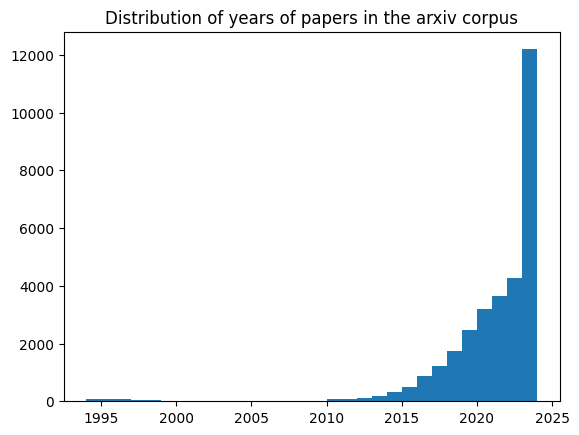

In [41]:
# distribution of dates
years = [p.year for p in corpus_arxiv.papers]
plt.hist(years, bins=range(min(years), max(years) + 1))
plt.title("Distribution of years of papers in the arxiv corpus")
plt.show()
